<a href="https://colab.research.google.com/github/aryan-at-ul/graph_from_patches/blob/main/contextclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

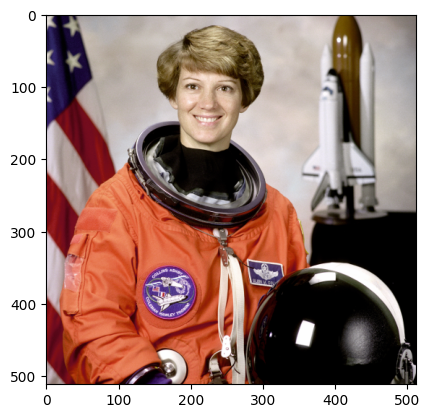

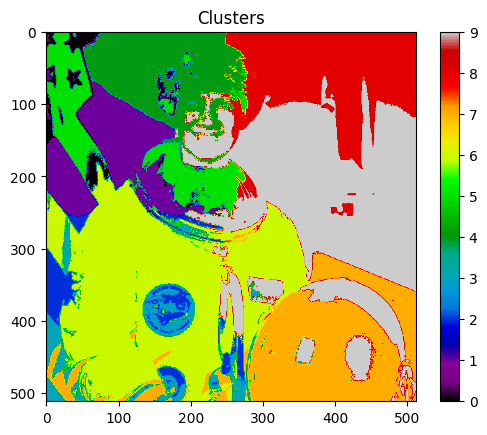

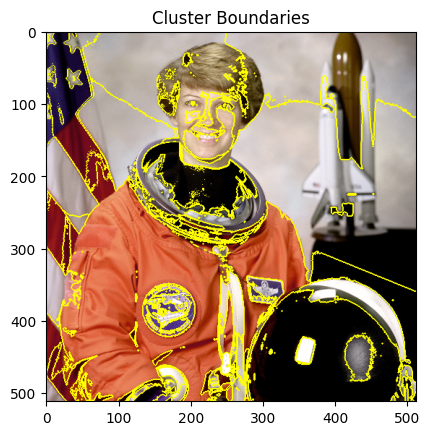

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, segmentation
from skimage.future import graph
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# def cluster_points(P, w, h, c, k):
#     Ps = P
#     x = np.linspace(-0.5, 0.5, int(np.sqrt(c)))
#     y = np.linspace(-0.5, 0.5, int(np.sqrt(c)))
#     grid_x, grid_y = np.meshgrid(x, y)
#     centers_xy = np.stack([grid_x.flatten(), grid_y.flatten()], axis=-1)
#     centers_rgb = np.zeros((c, 3))
#     nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, 3:])
#     _, indices = nbrs.kneighbors(centers_xy)
#     for i in range(c):
#         centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)
#     centers = np.hstack([centers_rgb, centers_xy])
#     S = cosine_similarity(Ps, centers)
#     cluster_assignments = np.argmax(S, axis=1)
#     return cluster_assignments

def cluster_points(P, w, h, c, k):
    # Adjust center creation to ensure c centers
    side_len = int(np.ceil(np.sqrt(c)))
    x = np.linspace(-0.5, 0.5, side_len)
    y = np.linspace(-0.5, 0.5, side_len)
    grid_x, grid_y = np.meshgrid(x, y)
    centers_xy = np.stack([grid_x.flatten(), grid_y.flatten()], axis=-1)[:c]  # Only take the first c centers
    centers_rgb = np.zeros((c, 3))

    # Get the k nearest points for each center and average to get the center features
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(P[:, 3:])
    _, indices = nbrs.kneighbors(centers_xy)
    for i in range(c):
        centers_rgb[i] = np.mean(P[indices[i], :3], axis=0)
    centers = np.hstack([centers_rgb, centers_xy])

    # Calculate cosine similarity
    S = cosine_similarity(P, centers)

    # Assign each point to the closest center
    cluster_assignments = np.argmax(S, axis=1)

    return cluster_assignments


# Load astronaut image
image = data.astronaut()
plt.imshow(image)
plt.show()
h, w, _ = image.shape

# Prepare the data
rgb = image.reshape(-1, 3) / 255.
xy = np.mgrid[0:h, 0:w].reshape(2, -1).T
xy = xy / np.array([h, w]) - 0.5
P = np.hstack([rgb, xy])

# Cluster points
c = 10
k = 4
assignments = cluster_points(P, w, h, c, k)

# Visualize the clusters
clustered_image = np.reshape(assignments, (h, w))
plt.imshow(clustered_image, cmap="nipy_spectral")
plt.colorbar()
plt.title('Clusters')
plt.show()

# Visualize the boundaries
edges = segmentation.mark_boundaries(image, clustered_image)
plt.imshow(edges)
plt.title('Cluster Boundaries')
plt.show()


this is the c 100
this is the c 100


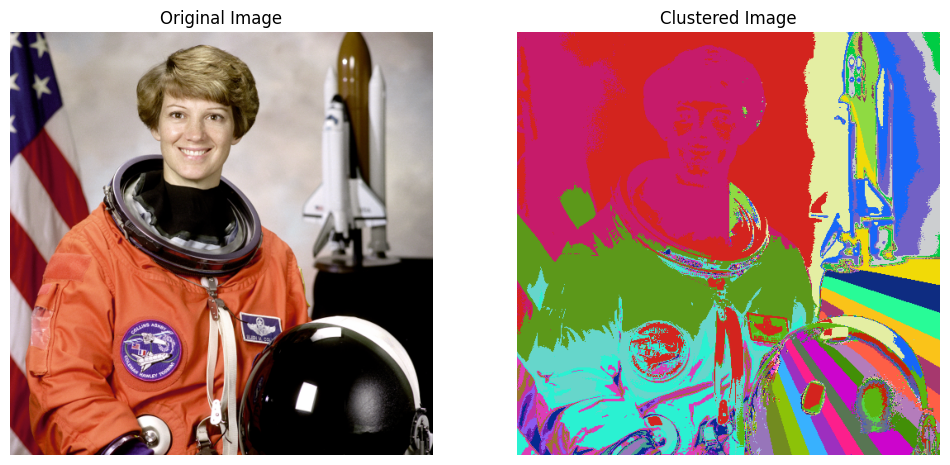

<ipython-input-57-715a232707a8>:120: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


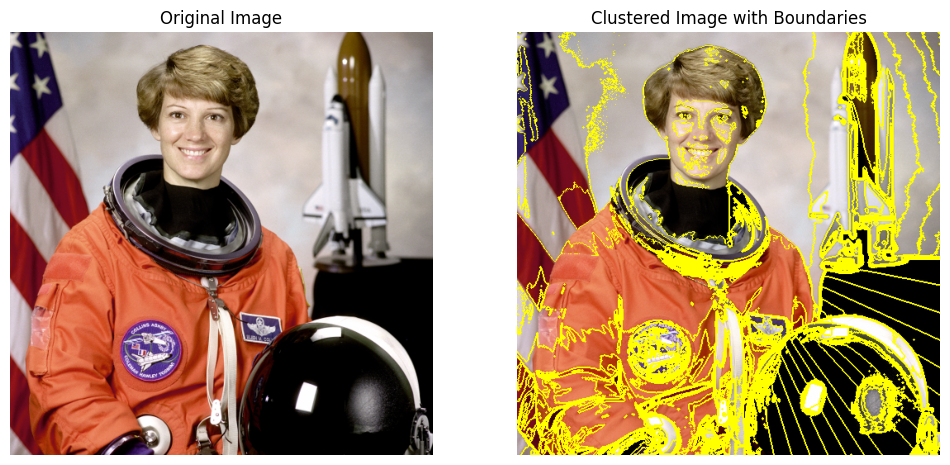

In [ ]:



import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors




def context_clustering(P, c, k):
    h, w  =   P.shape
    # Linearly project P for similarity computation
    Ps = P

    # Proposed c centers in space evenly
    y_centers = np.linspace(0, h-1, int(np.sqrt(c)))
    x_centers = np.linspace(0, w-1, int(np.sqrt(c)))

    # side_len = int(np.ceil(np.sqrt(c)))
    # y_centers = np.linspace(0, h-1, side_len)
    # x_centers = np.linspace(0, w-1, side_len)


    centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)
    centers_rgb = np.zeros((c, 3))

    # Averaging k-nearest points for center features
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
    _, indices = nbrs.kneighbors(centers_xy)
    for i in range(c):
        if len(indices[i]) == 0:
            continue
        centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)

    centers = np.hstack([centers_rgb, centers_xy / [w, h]])
    S = cosine_similarity(Ps, centers)

    # Assigning each point to the most similar center
    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []

    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    print("this is the c",c)
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features = []

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        # Feature aggregating , P, centers, S, c, alpha, beta
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching #P, aggregated_features, cluster_assignments, c, alpha, beta
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        aggregated_features.append(P_new)

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 100
k = 5
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, int(c), k, alpha, beta, d0, h)

# Re-use the clustering function to get the cluster assignments
# cluster_assignments, _, _ = context_clustering(P, c, k)
# print(np.unique(cluster_assignments, return_counts=True))


# # Visualize
# clustered_image = visualize_clusters(image, cluster_assignments)
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(image)
# axes[0].set_title('Original Image')
# axes[1].imshow(clustered_image)
# axes[1].set_title('Clustered Image')
# for ax in axes:
#     ax.axis('off')
# plt.show()
cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


this is the c 100
this is the c 100


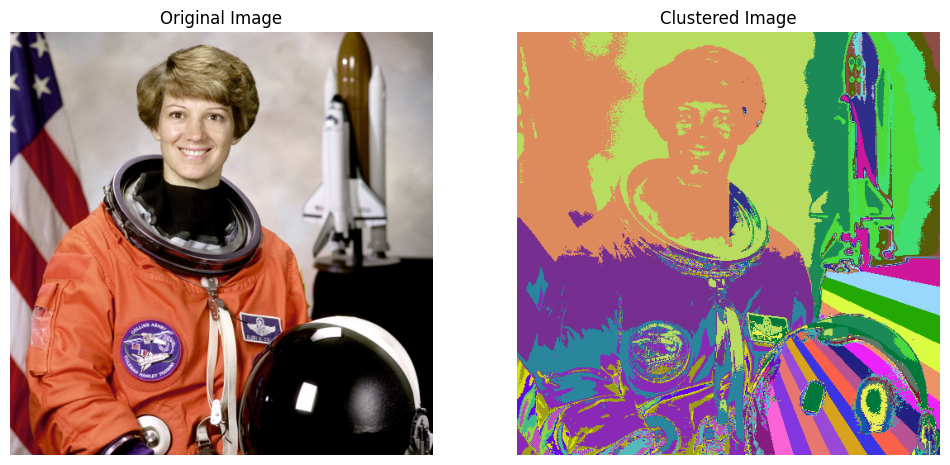

<ipython-input-61-c48fd4b1b334>:128: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


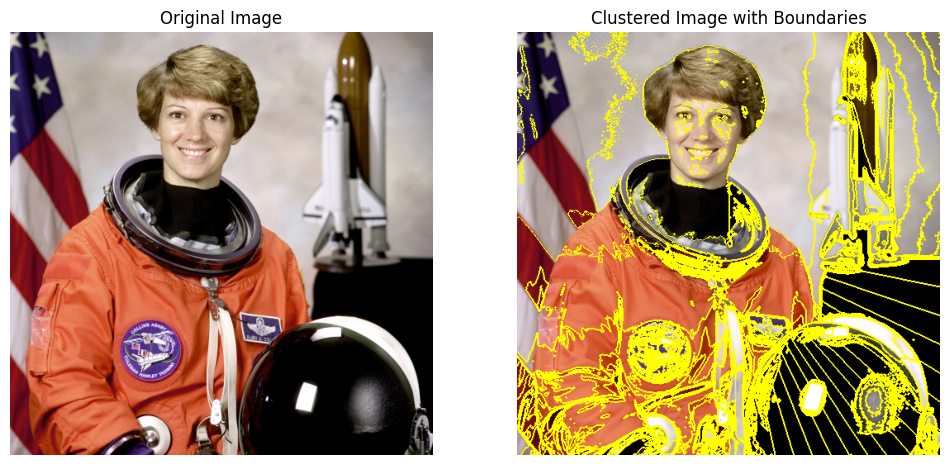

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

def context_clustering(P, c, k):
    h, w  = P.shape
    Ps = P

    side_len = int(np.ceil(np.sqrt(c)))
    y_centers = np.linspace(0, h-1, side_len)
    x_centers = np.linspace(0, w-1, side_len)

    centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)

    # Limiting the number of centers to c
    centers_xy = centers_xy[:c]

    centers_rgb = np.zeros((c, 3))

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
    _, indices = nbrs.kneighbors(centers_xy)

    for i in range(c):
        if len(indices[i]) == 0:
            continue
        centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)

    centers = np.hstack([centers_rgb, centers_xy / [w, h]])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []

    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    print("this is the c",c)
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features_list = []

    n_samples = P.shape[0]

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        # Feature aggregating
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        # Ensure the number of rows matches n_samples
        if P_new.shape[0] != n_samples:
            raise ValueError(f"Expected P_new to have {n_samples} rows but got {P_new.shape[0]} rows.")

        aggregated_features_list.append(P_new)

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((n_samples, diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 100
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)


cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


this is the c 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


this is the c 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


this is the c 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


this is the c 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


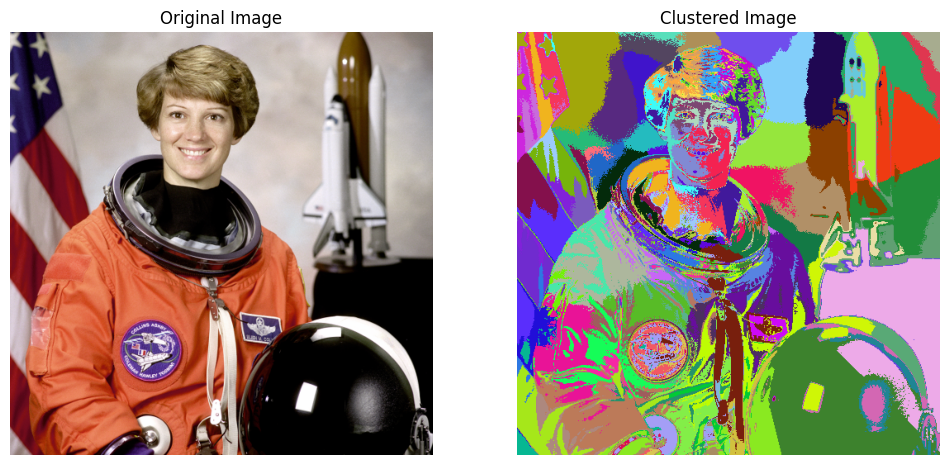

<ipython-input-13-16a4d33a14e2>:201: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from skimage import segmentation
from sklearn.cluster import KMeans

def context_clustering(P, c, k, n_components=None):
    h, w  = P.shape

    # If n_components is specified, perform PCA projection
    if n_components:
        pca = PCA(n_components=n_components)
        Ps = pca.fit_transform(P)
    else:
        Ps = P

    # Find RGB centers using k-means clustering
    kmeans = KMeans(n_clusters=c)
    kmeans.fit(Ps[:, :3])
    centers_rgb = kmeans.cluster_centers_

    # Find the RGB values corresponding to the centers using nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, :3])
    distances, indices = nbrs.kneighbors(centers_rgb)

    valid_centers = []
    valid_rgb_centers = []

    for i in range(c):
        if len(indices[i]) == 0 or np.any(distances[i] == 0):
            continue
        valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
        valid_centers.append(np.mean(Ps[indices[i], 3:], axis=0))  # take the spatial mean for valid centers

    centers_xy = np.array(valid_centers)  # Update centers_xy to only have valid centers
    centers_rgb = np.array(valid_rgb_centers)

    if len(centers_xy) == 0:
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid centers are found

    centers = np.hstack([centers_rgb, centers_xy])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S

# def context_clustering(P, c, k):
#     h, w  = P.shape
# #     Ps = P
# def context_clustering(P, c, k, n_components=None):
#     h, w  = P.shape
#     print(P.shape)

#     # If n_components is specified, perform PCA projection
#     if n_components:
#         pca = PCA(n_components=n_components)
#         Ps = pca.fit_transform(P)
#     else:
#         Ps = P
#     # Create the centers based on spatial location
#     side_len = int(np.ceil(np.sqrt(c)))
#     y_centers = np.linspace(0, h-1, side_len)
#     x_centers = np.linspace(0, w-1, side_len)
#     centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)
#     centers_xy = centers_xy[:c]  # Limiting the number of centers to c
#     print(centers_xy)

#     # Find the RGB values corresponding to the centers using nearest neighbors
#     nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
#     distances, indices = nbrs.kneighbors(centers_xy)

#     if indices is None or len(indices) == 0:
#         return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid indices are found

#     valid_centers = []
#     valid_rgb_centers = []

#     for i in range(c):
#         if len(indices[i]) == 0 or np.any(distances[i] == 0):
#             continue
#         valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
#         valid_centers.append(centers_xy[i])

#     centers_xy = np.array(valid_centers)  # Update centers_xy to only have valid centers
#     centers_rgb = np.array(valid_rgb_centers)

#     if len(centers_xy) == 0:
#         return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid centers are found

#     centers = np.hstack([centers_rgb, centers_xy / [w, h]])
#     S = cosine_similarity(Ps, centers)

#     cluster_assignments = np.argmax(S, axis=1)
#     return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []
    c = centers.shape[0]
    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    c = len(aggregated_features)
    print("this is the c",c)
    for i in range(c):

        indices = np.where(cluster_assignments == i)[0]
        if len(indices) == 0:  # Check if indices is empty
            continue
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        # indices = np.where(cluster_assignments == i)[0]
        # s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features_list = []

    n_samples = P.shape[0]

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue


        # Feature aggregating
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        # Ensure the number of rows matches n_samples
        if P_new.shape[0] != n_samples:
            raise ValueError(f"Expected P_new to have {n_samples} rows but got {P_new.shape[0]} rows.")

        aggregated_features_list.append(P_new)

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((n_samples, diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 100
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 1

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)


cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

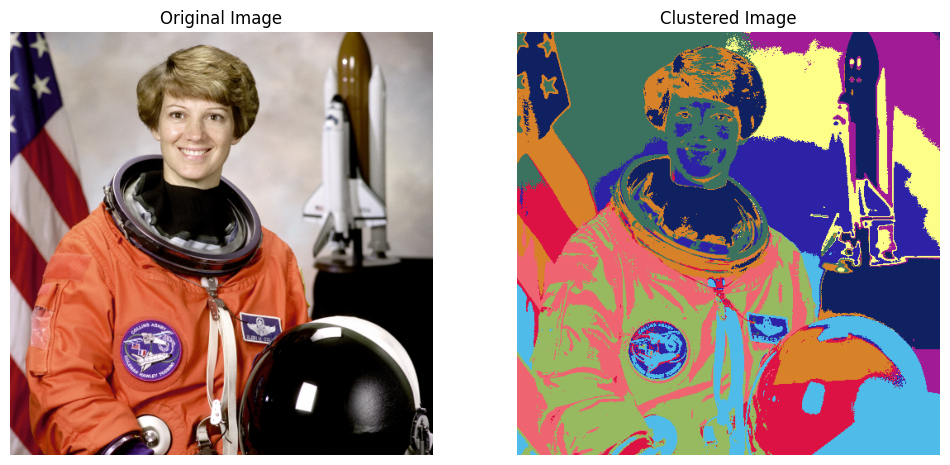

<ipython-input-33-42644ab0f21e>:186: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


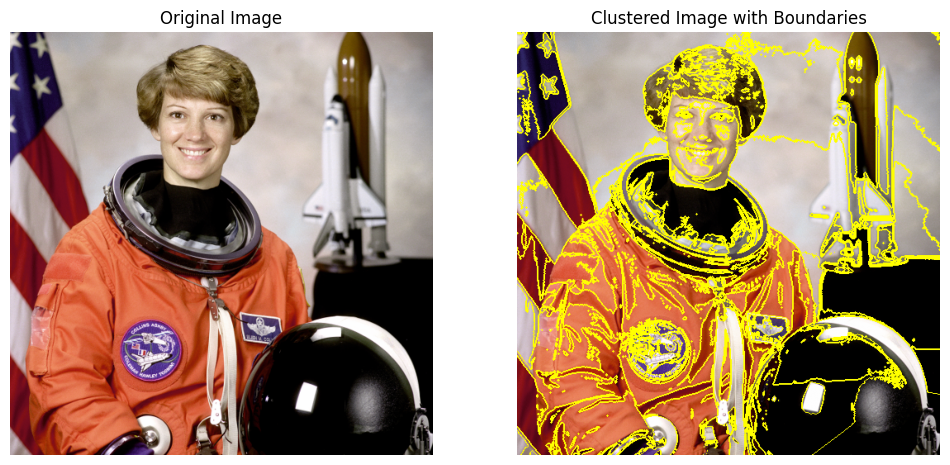

In [33]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from skimage import segmentation
from sklearn.cluster import KMeans
import torch
import torch.nn as nn


class FusionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FusionLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)



def context_clustering(P, c, k, n_components=None):
    h, w  = P.shape

    # If n_components is specified, perform PCA projection
    # if n_components:
    #     pca = PCA(n_components=n_components)
    #     Ps = pca.fit_transform(P)
    # else:
    Ps = P

    # Find RGB centers using k-means clustering
    kmeans = KMeans(n_clusters=c)
    kmeans.fit(Ps[:, :3])
    centers_rgb = kmeans.cluster_centers_

    # Find the RGB values corresponding to the centers using nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, :3])
    distances, indices = nbrs.kneighbors(centers_rgb)

    valid_centers = []
    valid_rgb_centers = []

    for i in range(c):
        if len(indices[i]) == 0 or np.any(distances[i] == 0):
            continue
        valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
        valid_centers.append(np.mean(Ps[indices[i], 3:], axis=0))  # take the spatial mean for valid centers

    centers_xy = np.array(valid_centers)  # Update centers_xy to only have valid centers
    centers_rgb = np.array(valid_rgb_centers)

    if len(centers_xy) == 0:
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid centers are found

    centers = np.hstack([centers_rgb, centers_xy])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha):
    new_P = P.copy()
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        for idx in indices:
            new_P[idx, :3] = alpha * P[idx, :3] + (1 - alpha) * aggregated_features[i] # Update only RGB features
    return new_P




def feature_aggregating(P, centers_rgb, S, c, alpha, beta):
    aggregated_features = []
    for i in range(c):
        s = S[:, i]
        Pv_rgb = P[:, :3]  # Only use RGB data
        vc = centers_rgb[i]


        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv_rgb, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features


def multi_head_computing(P, c, k, alpha, beta, d0, h, device='cpu'):
    aggregated_features_list = []

    n_samples = P.shape[0]

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        centers_rgb = centers[:, :3]

        # Feature aggregating
        g = feature_aggregating(P, centers_rgb, S, c, alpha, beta)

        # Feature dispatching
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha)

        # Ensure the number of rows matches n_samples
        if P_new.shape[0] != n_samples:
            raise ValueError(f"Expected P_new to have {n_samples} rows but got {P_new.shape[0]} rows.")

        aggregated_features_list.append(P_new)

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((n_samples, diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    concatenated_features = np.concatenate(aggregated_features_list, axis=1)

    # Fusion with a Fully-Connected (FC) layer using PyTorch
    fusion_layer = FusionLayer(concatenated_features.shape[1], P.shape[1]).to(device)
    with torch.no_grad():
        new_P = fusion_layer(torch.tensor(concatenated_features, dtype=torch.float32).to(device)).cpu().numpy()

    return new_P


def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image


def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 10
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 4

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)#prev working


cluster_assignments, _, _ = context_clustering(new_P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-51-a34e661f6042>:276: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


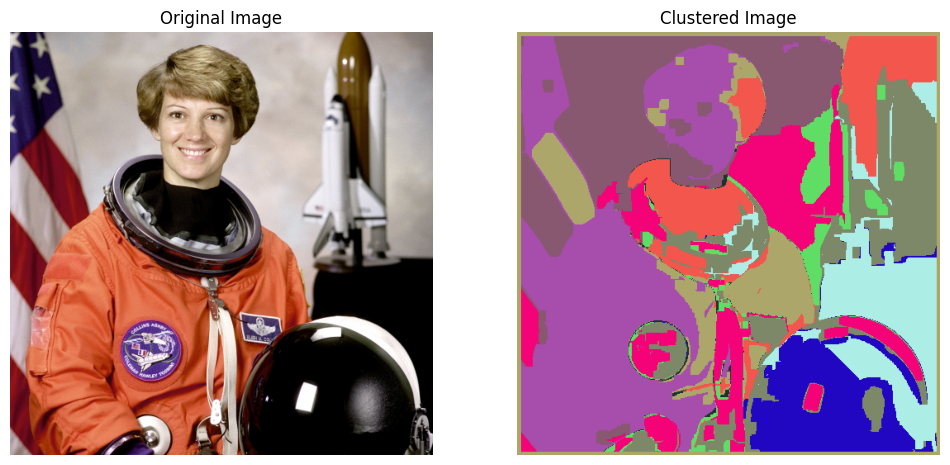

<ipython-input-51-a34e661f6042>:160: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


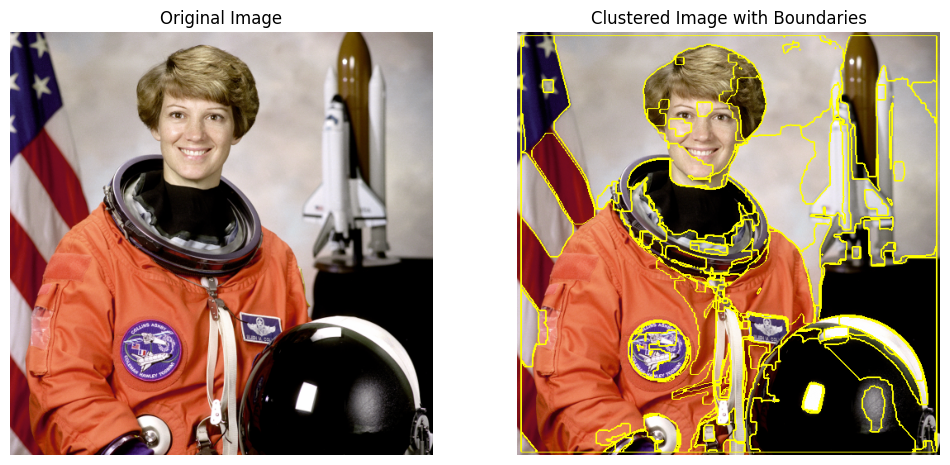

In [51]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from skimage import segmentation
from sklearn.cluster import KMeans
import torch
import torch.nn as nn

import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


# Define the MLP layer
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super(Mlp, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        # Linear layers to process 1D data
        self.fc1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.GELU(),
            nn.BatchNorm1d(hidden_features)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


# Context Clustering: Assign each point in P to a cluster based on color similarity
def context_clustering(P, c, k):
    h, w = P.shape
    Ps = P

    kmeans = KMeans(n_clusters=c)
    kmeans.fit(Ps[:, :3])
    centers_rgb = kmeans.cluster_centers_

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, :3])
    distances, indices = nbrs.kneighbors(centers_rgb)

    valid_centers = []
    valid_rgb_centers = []

    for i in range(c):
        if len(indices[i]) == 0 or np.any(distances[i] == 0):
            continue
        valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
        valid_centers.append(np.mean(Ps[indices[i], 3:], axis=0))

    centers_xy = np.array(valid_centers)
    centers_rgb = np.array(valid_rgb_centers)

    if len(centers_xy) == 0:
        return np.array([]), np.array([]), np.array([])

    centers = np.hstack([centers_rgb, centers_xy])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S


# Feature Aggregation: Aggregate the features of points in each cluster
def feature_aggregating(P, centers_rgb, S, c, alpha, beta):
    aggregated_features = []
    for i in range(c):
        s = S[:, i]
        Pv_rgb = P[:, :3]
        vc = centers_rgb[i]

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv_rgb, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features


# Feature Dispatching: Dispatch the aggregated features to all points in the cluster
def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha):
    new_P = P.copy()
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        for idx in indices:
            new_P[idx, :3] = alpha * P[idx, :3] + (1 - alpha) * aggregated_features[i]
    return new_P


# Multi-head Computing: Incorporate multi-head mechanism for enhancing context clustering
def multi_head_computing(P, c, k, alpha, beta, d0, h, device='cpu'):
    aggregated_features_list = []

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        centers_rgb = centers[:, :3]
        g = feature_aggregating(P, centers_rgb, S, c, alpha, beta)
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha)

        # Fusion using the MLP layer
        mlp_layer = Mlp(P_new.shape[1], d0, P.shape[1]).to(device)
        with torch.no_grad():
            P_new = mlp_layer(torch.tensor(P_new, dtype=torch.float32).to(device)).cpu().numpy()

        aggregated_features_list.append(P_new)
        P = P_new

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((P.shape[0], diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)

    return new_P


def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image


def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

def merge_small_clusters(P, cluster_assignments, threshold=10):
    """
    Merge small clusters based on feature and spatial proximity.

    :param P: Feature matrix, including RGB and spatial information.
    :param cluster_assignments: Array with cluster ids for each point.
    :param threshold: Size threshold below which clusters are considered 'small'.
    :return: New cluster assignments with small clusters merged.
    """
    unique_clusters, counts = np.unique(cluster_assignments, return_counts=True)
    small_clusters = unique_clusters[counts < threshold]

    # Extract the RGB and spatial portions of P for all clusters
    features_rgb = P[:, :3]
    features_xy = P[:, 3:]

    # Compute mean feature and spatial positions for all clusters
    cluster_means_rgb = {cluster: np.mean(features_rgb[cluster_assignments == cluster], axis=0) for cluster in unique_clusters}
    cluster_means_xy = {cluster: np.mean(features_xy[cluster_assignments == cluster], axis=0) for cluster in unique_clusters}

    for cluster in small_clusters:
        mean_rgb = cluster_means_rgb[cluster]
        mean_xy = cluster_means_xy[cluster]

        distances = []

        for unique_cluster in unique_clusters:
            if unique_cluster == cluster:
                continue

            distance_rgb = np.linalg.norm(mean_rgb - cluster_means_rgb[unique_cluster])
            distance_xy = np.linalg.norm(mean_xy - cluster_means_xy[unique_cluster])

            # Combine feature and spatial distances with a weight to adjust the importance (here, 0.5 for equal importance)
            combined_distance = 0.5 * distance_rgb + 0.5 * distance_xy

            distances.append(combined_distance)

        # Find the closest cluster
        closest_cluster = unique_clusters[np.argmin(distances)]

        # Update the cluster assignment
        cluster_assignments[cluster_assignments == cluster] = closest_cluster

    return cluster_assignments



# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 10
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)#prev working


# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(cluster_assignments, threshold=5)  # you can adjust the threshold as needed
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def smooth_clusters_with_superpixels(image, cluster_assignments):
    """
    Use SLIC superpixels to enforce spatial smoothness in cluster assignments.

    :param image: Original image.
    :param cluster_assignments: Cluster assignments for each pixel.
    :return: Smoothed cluster assignments.
    """
    # Use SLIC to compute superpixels
    superpixels = slic(image, n_segments=np.unique(cluster_assignments).size, compactness=30, sigma=3)

    # For each superpixel, assign it the most frequent cluster label within it
    for segment_val in np.unique(superpixels):
        segment_mask = superpixels == segment_val
        # Count the occurrences of each cluster within the superpixel
        cluster_counts = np.bincount(cluster_assignments[segment_mask])
        most_frequent_cluster = cluster_counts.argmax()
        # Assign the most frequent cluster label to the entire superpixel
        cluster_assignments[segment_mask] = most_frequent_cluster

    return cluster_assignments


from scipy.ndimage.morphology import binary_closing

def morphological_smoothing(cluster_assignments, image_shape, structure_size=3):
    """Smooth clusters using morphological operations."""
    # Initialize a blank image to store the results
    smoothed_clusters = np.zeros(image_shape, dtype=cluster_assignments.dtype)

    for label in np.unique(cluster_assignments):
        binary_image = (cluster_assignments == label)
        smoothed_binary_image = binary_closing(binary_image, structure=np.ones((structure_size, structure_size)))
        smoothed_clusters[smoothed_binary_image] = label

    return smoothed_clusters

# Correctly retrieve the image dimensions
image_h, image_w, _ = image.shape

# Cluster the data
cluster_assignments, _, _ = context_clustering(new_P, c, k)
cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=5)  # adjust the threshold as needed

# Smooth the clusters
cluster_assignments_reshaped = cluster_assignments.reshape(image_h, image_w)
smoothed_clusters = morphological_smoothing(cluster_assignments_reshaped, (image_h, image_w), structure_size=10)
cluster_assignments_smoothed = smoothed_clusters.flatten()
cluster_assignments = cluster_assignments_smoothed
# After your existing code...
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
# cluster_assignments = smooth_clusters_with_superpixels(image, cluster_assignments.reshape(h, w)).flatten()
# image_h, image_w, _ = image.shape

# # After your existing code...
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
# cluster_assignments = smooth_clusters_with_superpixels(image, cluster_assignments.reshape(image_h, image_w)).flatten()


# Visualization remains the same

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-55-680482ebd700>:276: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


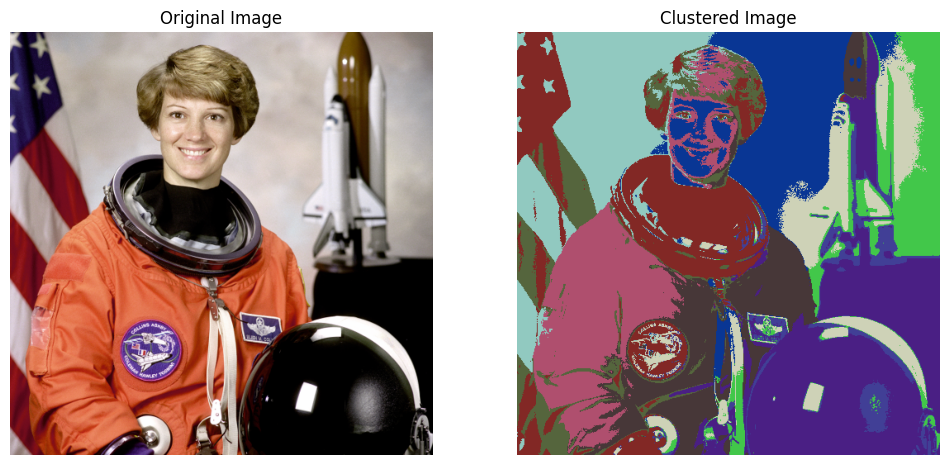

<ipython-input-55-680482ebd700>:160: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


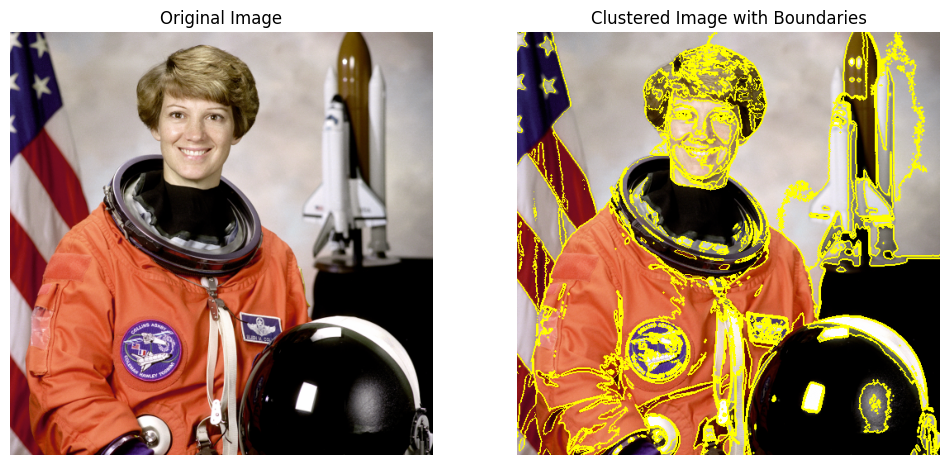

In [55]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from skimage import segmentation
from sklearn.cluster import KMeans
import torch
import torch.nn as nn

import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


# Define the MLP layer
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super(Mlp, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        # Linear layers to process 1D data
        self.fc1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.GELU(),
            nn.BatchNorm1d(hidden_features)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


# Context Clustering: Assign each point in P to a cluster based on color similarity
def context_clustering(P, c, k):
    h, w = P.shape
    Ps = P

    kmeans = KMeans(n_clusters=c)
    kmeans.fit(Ps[:, :3])
    centers_rgb = kmeans.cluster_centers_

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, :3])
    distances, indices = nbrs.kneighbors(centers_rgb)

    valid_centers = []
    valid_rgb_centers = []

    for i in range(c):
        if len(indices[i]) == 0 or np.any(distances[i] == 0):
            continue
        valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
        valid_centers.append(np.mean(Ps[indices[i], 3:], axis=0))

    centers_xy = np.array(valid_centers)
    centers_rgb = np.array(valid_rgb_centers)

    if len(centers_xy) == 0:
        return np.array([]), np.array([]), np.array([])

    centers = np.hstack([centers_rgb, centers_xy])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S


# Feature Aggregation: Aggregate the features of points in each cluster
def feature_aggregating(P, centers_rgb, S, c, alpha, beta):
    aggregated_features = []
    for i in range(c):
        s = S[:, i]
        Pv_rgb = P[:, :3]
        vc = centers_rgb[i]

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv_rgb, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features


# Feature Dispatching: Dispatch the aggregated features to all points in the cluster
def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha):
    new_P = P.copy()
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        for idx in indices:
            new_P[idx, :3] = alpha * P[idx, :3] + (1 - alpha) * aggregated_features[i]
    return new_P


# Multi-head Computing: Incorporate multi-head mechanism for enhancing context clustering
def multi_head_computing(P, c, k, alpha, beta, d0, h, device='cpu'):
    aggregated_features_list = []

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        centers_rgb = centers[:, :3]
        g = feature_aggregating(P, centers_rgb, S, c, alpha, beta)
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha)

        # Fusion using the MLP layer
        mlp_layer = Mlp(P_new.shape[1], d0, P.shape[1]).to(device)
        with torch.no_grad():
            P_new = mlp_layer(torch.tensor(P_new, dtype=torch.float32).to(device)).cpu().numpy()

        aggregated_features_list.append(P_new)
        P = P_new

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((P.shape[0], diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)

    return new_P


def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image


def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

def merge_small_clusters(P, cluster_assignments, threshold=10):
    """
    Merge small clusters based on feature and spatial proximity.

    :param P: Feature matrix, including RGB and spatial information.
    :param cluster_assignments: Array with cluster ids for each point.
    :param threshold: Size threshold below which clusters are considered 'small'.
    :return: New cluster assignments with small clusters merged.
    """
    unique_clusters, counts = np.unique(cluster_assignments, return_counts=True)
    small_clusters = unique_clusters[counts < threshold]

    # Extract the RGB and spatial portions of P for all clusters
    features_rgb = P[:, :3]
    features_xy = P[:, 3:]

    # Compute mean feature and spatial positions for all clusters
    cluster_means_rgb = {cluster: np.mean(features_rgb[cluster_assignments == cluster], axis=0) for cluster in unique_clusters}
    cluster_means_xy = {cluster: np.mean(features_xy[cluster_assignments == cluster], axis=0) for cluster in unique_clusters}

    for cluster in small_clusters:
        mean_rgb = cluster_means_rgb[cluster]
        mean_xy = cluster_means_xy[cluster]

        distances = []

        for unique_cluster in unique_clusters:
            if unique_cluster == cluster:
                continue

            distance_rgb = np.linalg.norm(mean_rgb - cluster_means_rgb[unique_cluster])
            distance_xy = np.linalg.norm(mean_xy - cluster_means_xy[unique_cluster])

            # Combine feature and spatial distances with a weight to adjust the importance (here, 0.5 for equal importance)
            combined_distance = 0.5 * distance_rgb + 0.5 * distance_xy

            distances.append(combined_distance)

        # Find the closest cluster
        closest_cluster = unique_clusters[np.argmin(distances)]

        # Update the cluster assignment
        cluster_assignments[cluster_assignments == cluster] = closest_cluster

    return cluster_assignments



# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 10
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)#prev working


# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(cluster_assignments, threshold=5)  # you can adjust the threshold as needed
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def smooth_clusters_with_superpixels(image, cluster_assignments):
    """
    Use SLIC superpixels to enforce spatial smoothness in cluster assignments.

    :param image: Original image.
    :param cluster_assignments: Cluster assignments for each pixel.
    :return: Smoothed cluster assignments.
    """
    # Use SLIC to compute superpixels
    superpixels = slic(image, n_segments=np.unique(cluster_assignments).size, compactness=30, sigma=3)

    # For each superpixel, assign it the most frequent cluster label within it
    for segment_val in np.unique(superpixels):
        segment_mask = superpixels == segment_val
        # Count the occurrences of each cluster within the superpixel
        cluster_counts = np.bincount(cluster_assignments[segment_mask])
        most_frequent_cluster = cluster_counts.argmax()
        # Assign the most frequent cluster label to the entire superpixel
        cluster_assignments[segment_mask] = most_frequent_cluster

    return cluster_assignments


from scipy.ndimage.morphology import binary_closing

def morphological_smoothing(cluster_assignments, image_shape, structure_size=3):
    """Smooth clusters using morphological operations."""
    # Initialize a blank image to store the results
    smoothed_clusters = np.zeros(image_shape, dtype=cluster_assignments.dtype)

    for label in np.unique(cluster_assignments):
        binary_image = (cluster_assignments == label)
        smoothed_binary_image = binary_closing(binary_image, structure=np.ones((structure_size, structure_size)))
        smoothed_clusters[smoothed_binary_image] = label

    return smoothed_clusters

# Correctly retrieve the image dimensions
image_h, image_w, _ = image.shape

# Cluster the data
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=5)  # adjust the threshold as needed

# # Smooth the clusters
# cluster_assignments_reshaped = cluster_assignments.reshape(image_h, image_w)
# smoothed_clusters = morphological_smoothing(cluster_assignments_reshaped, (image_h, image_w), structure_size=10)
# cluster_assignments_smoothed = smoothed_clusters.flatten()
# cluster_assignments = cluster_assignments_smoothed
def merge_clusters_contained_within_others(cluster_assignments):
    unique_clusters = np.unique(cluster_assignments)

    # Loop over each unique cluster
    for label in unique_clusters:
        current_mask = (cluster_assignments == label)

        # Check other clusters
        for other_label in unique_clusters:
            if other_label == label:
                continue  # Skip the current cluster

            other_mask = (cluster_assignments == other_label)

            # Check if the current cluster is entirely within the other cluster
            if np.all(np.logical_or(np.logical_not(current_mask), other_mask)):
                cluster_assignments[current_mask] = other_label
                break  # Exit the inner loop as the cluster has been merged

    return cluster_assignments

# Cluster the data
cluster_assignments, _, _ = context_clustering(new_P, c, k)
cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=5)  # adjust the threshold as needed

# Merge contained clusters
cluster_assignments_merged = merge_clusters_contained_within_others(cluster_assignments)
cluster_assignments = cluster_assignments_merged



# After your existing code...
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
# cluster_assignments = smooth_clusters_with_superpixels(image, cluster_assignments.reshape(h, w)).flatten()
# image_h, image_w, _ = image.shape

# # After your existing code...
# cluster_assignments, _, _ = context_clustering(new_P, c, k)
# cluster_assignments = merge_small_clusters(new_P, cluster_assignments, threshold=10)  # adjust the threshold as needed
# cluster_assignments = smooth_clusters_with_superpixels(image, cluster_assignments.reshape(image_h, image_w)).flatten()


# Visualization remains the same

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()
